## Problem Stament: The goal of project was to create a classification model to predict where a post originated from r/cartoons or r/anime.

1. We try to find the most important words in classifying posts. 
2. Deduce why those word are deemed important by the model.

## Methods: 

Use Reddit’s API to web scrape from our subreddit of interest.
1. We then focus on the title of the posts and selftext for analysis
2. We run two models:
3. Naive Bayes with Count Vectorized
4. Naive Bayes with TF-IDF
 
## Contents: 
1. EDA
2. Multinomial Naive Bayes Model

In [62]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
import requests, re
import requests
import time
from datetime import datetime
import regex as re

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# EDA and Preprocessing

In [5]:
# enter subreddit urls
anime_url = 'https://www.reddit.com/r/anime.json'
cartoon_url = 'https://www.reddit.com/r/cartoons.json'
# establish our header
header = {'User-agent': 'subreddit get requests'}

In [6]:
# initial get request to test API
res = requests.get(anime_url, headers=header)
anime_res = res.json()

In [7]:
# check request status
res.status_code

200

In [8]:
# define function to get num pages of posts from a subreddit, start collecting at a defined after
def reddit_scraper(url, num, after = None):
    posts = []
    # loop through the num pages, each subreddit .json returns 25 posts 
    for page in range(num):
        # initiate params modifier for posts if there no defined after
        if after == None:
            params = {}
        # add in after id for each loop following to ensure no duplicate posts
        else:
            params = {'after': after}
        # call our get request for the posts
        res = requests.get(url, params=params, headers=header)
        # check status code, 200 means posts were successfully downloaded
        if res.status_code == 200:
            # convert request to .json
            new_json = res.json()
            # extend list from the 'children' dictionary for each request
            posts.extend(new_json['data']['children'])
            # update after id
            after = new_json['data']['after']
        else:
            # print status code if not 200
            print(res.status_code)
            break
        if page % 100 == 0:
            print(page, 'request of ', num)
        # wait 1 second
        time.sleep(.5)
        
    # create a new dataframe with the 'data' from each post
    new_df = pd.DataFrame([post['data'] for post in posts])   
    # return the dataframe
    return new_df

In [444]:
anime_df = reddit_scraper(anime_url, 2000)
cartoon_df = reddit_scraper(cartoon_url, 2000)

0 request of  2000
100 request of  2000


KeyboardInterrupt: 

In [349]:
anime_df.shape

(17128, 112)

In [350]:
cartoon_df.shape

(13678, 117)

In [351]:
anime_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,url_overridden_by_dest,media_metadata,author_cakeday
0,None,anime,A monthly thread to talk about meta topics. Ke...,t2_6wrl6,False,None,0,False,"Meta Thread - Month of August 01, 2021","[{'e': 'text', 't': 'Meta'}]",...,2640547,1.627776e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
1,None,anime,This is a weekly thread to get to know /r/anim...,t2_6l4z3,False,None,0,False,"Casual Discussion Fridays - Week of August 06,...","[{'e': 'text', 't': 'Weekly'}]",...,2640547,1.628208e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
2,None,anime,,t2_29lwdgfk,False,None,0,False,Chika trying to whistle [Kaguya Sama Love is War],"[{'e': 'text', 't': 'Clip'}]",...,2640547,1.628149e+09,2,"{'reddit_video': {'bitrate_kbps': 4800, 'fallb...",True,hosted:video,{'images': [{'source': {'url': 'https://extern...,https://v.redd.it/3vpxiyfkthf71,NaN,NaN
3,None,anime,"*Sonny Boy*, episode 4\n\n\n\n# [Rate this epi...",t2_1jzq3sy,False,None,0,False,Sonny Boy - Episode 4 discussion,"[{'e': 'text', 't': 'Episode'}]",...,2640547,1.628181e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
4,None,anime,"*Heion Sedai no Idaten-tachi*, episode 4\n\nAl...",t2_1jzq3sy,False,None,0,False,Heion Sedai no Idaten-tachi - Episode 4 discus...,"[{'e': 'text', 't': 'Episode'}]",...,2640547,1.628189e+09,0,None,False,NaN,NaN,NaN,NaN,NaN


In [352]:
anime_df.to_csv("./data/anime_subreddit_data.csv", index=False)
cartoon_df.to_csv("./data/cartoon_subreddit_data.csv", index=False)

In [9]:
anime_df = pd.read_csv('./data/anime_subreddit_data.csv')
cartoon_df = pd.read_csv('./data/cartoon_subreddit_data.csv')

In [10]:
# define function to combine two subsets of columns
# fills NaN's with null strings to ensure compatability
def combine_text(df, cols):
    for col in cols:
        df[col] = df[col].fillna(value = "")
    return df[cols].apply(lambda x: ''.join(x), axis=1)

In [11]:
anime_df['text'] = combine_text(anime_df,['title', 'selftext'])

In [12]:
cartoon_df['text'] = combine_text(cartoon_df,['title', 'selftext'])

In [13]:
anime_df = anime_df [['text', 'name', 'subreddit']]

In [14]:
cartoon_df = cartoon_df [['text', 'name', 'subreddit']]

In [15]:
# drop duplicate posts based on the post name ID
anime_df = anime_df.drop_duplicates(subset=['name'])
cartoon_df = cartoon_df.drop_duplicates(subset=['name'])

In [16]:
anime_df

,text,name,subreddit
0,"Meta Thread - Month of August 01, 2021A monthl...",t3_ovhuxg,anime
1,"Casual Discussion Fridays - Week of August 06,...",t3_oyv4ng,anime
2,Chika trying to whistle [Kaguya Sama Love is War],t3_oycncn,anime
3,"Sonny Boy - Episode 4 discussion*Sonny Boy*, e...",t3_oym5ka,anime
4,Heion Sedai no Idaten-tachi - Episode 4 discus...,t3_oyopz3,anime
...,...,...,...
5166,Am I a traitor?I've been a shinobi of the Hidd...,t3_oyvmjr,anime
8075,Is Jujutsu Kaisen worth the watch?I’ve been in...,t3_oyvnwd,anime
8801,What trashy seasonal anime have you enjoyed mo...,t3_oyvocr,anime
8802,New Weeb Anthem (oc),t3_oyvo48,anime


In [17]:
# concat the nfl and nba dataframes
reddit = pd.concat([anime_df, cartoon_df], ignore_index=True)

In [18]:
reddit.shape

(1709, 3)

In [19]:
# define function to run same regex over a dataframe
def sub_preprocess(sub):
    # run regex to remove urls
    sub['text'] = sub['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove certain characters
    sub['text'] = sub['text'].map(lambda x: re.sub(r"[@\?\.$%_\[\]()+-:*\"]", ' ', x, flags=re.I))
    sub['text'] = sub['text'].map(lambda x: re.sub(r"[,']", '', x, flags=re.I))
    sub['text'] = sub['text'].map(lambda x: re.sub("(?<![\w'])\w+?(?=\b|'s)", ' ', x))

    # run regex to remove line breaks and tabs
    sub['text'] = sub['text'].map(lambda x: re.sub(r"\s+", ' ', x))

    # run regex to remove common words
    sub['text'] = sub['text'].map(lambda x: re.sub('(of|in|This|to|and)', ' ', x))            
    

In [20]:
# run the regex function on our dataframes
sub_preprocess(reddit)

In [21]:
reddit['is_anime'] = reddit['subreddit'].map(lambda x: 1 if x == 'anime' else 0)

In [22]:
reddit['is_anime'].value_counts(normalize=True)

0    0.571679
1    0.428321
Name: is_anime, dtype: float64

In [23]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Multinomial Naive Bayes Model

In [24]:
# train/test split our data
X = reddit['text']
y = reddit['is_anime']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [25]:
# instantiate pipeline
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [26]:
# define gridsearch hyperparameters
tfidf_params = {
    'tfidf__max_features': [2000, 5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [.60, .75, .90],
    'tfidf__stop_words': [None, 'english']
}

In [27]:
# run gridsearch
tfidf_gs = GridSearchCV(tfidf_pipe, param_grid=tfidf_params, cv=3, n_jobs=4)
tfidf_gs.fit(X_train, y_train)

# display best hyperparameters
tfidf_gs.best_params_

{'tfidf__max_df': 0.6,
 'tfidf__max_features': 20000,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [28]:
#check score from training data
tfidf_gs.score(X_train, y_train)

0.9937548790007806

In [29]:
# check score from predictions on testing data
y_pred_class = tfidf_gs.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.9018691588785047

In [30]:
# instantiate pipeline
cvec_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [31]:
# define gridsearch parameters
cvec_params = {
    'cvec__max_features': [2000, 5000, 10000, 20000],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__max_df': [.60, .75, .95],
    'cvec__stop_words': [None, 'english']
}

In [32]:
# run gridsearch
cvec_gs = GridSearchCV(cvec_pipe, param_grid=cvec_params, cv=3, n_jobs=4)
cvec_gs.fit(X_train, y_train)

# display best hyperparameters
cvec_gs.best_params_

{'cvec__max_df': 0.6,
 'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [33]:
# check score from training data
cvec_gs.score(X_train, y_train)

0.9375487900078064

In [34]:
# check score from predictions on testing data
y_pred_class = cvec_gs.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)

0.8785046728971962

In [35]:
# use the parameters found in the gridsearch
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=10000, max_df=0.60)

In [36]:
# run the TF-IDF vectorized model with optimal parameters
train_raw = tfidf.fit_transform(X_train)
train_df = pd.DataFrame(train_raw.toarray(), columns=tfidf.get_feature_names())

test_raw = tfidf.transform(X_test)
test_df = pd.DataFrame(test_raw.toarray(), columns=tfidf.get_feature_names())

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [37]:
tfidf_nb = MultinomialNB()
tfidf_nb.fit(train_df, y_train)

MultinomialNB()

In [38]:
# score model on testing set
tfidf_nb.score(test_raw, y_test)

0.897196261682243

In [39]:
# define fucntion to determine the most useful features for  Multinomial NB classifiers
def nb_features(vectorizer, classifier, n=20, class_labels=[0, 1]):
    
    # get list of feature names from the vectorizor
    feature_names = vectorizer.get_feature_names()
    
    # two lists of tuples that contain the log probability from the classifier
    # tie it to the corresponding feature names, sort the list by highest log probability
    top_class0 = sorted(zip(classifier.feature_log_prob_[0], feature_names), reverse=True)[:n]
    top_class1 = sorted(zip(classifier.feature_log_prob_[1], feature_names), reverse=True)[:n]
    # credit to Sai Sandeep on StackOverflow for giving the basis for the zip method of tying names and counts together
    
    print(f"Important words in classifying posts for {class_labels[0]}")
    
    # print label, the exponential of the log probability,  and the feature names
    for prob, feat in top_class0:
        print(class_labels[0], np.exp(prob), feat)

    print(" ")
    print(" ")
    print(f"Important words in classifying posts for {class_labels[1]}")

    for prob, feat in top_class1:
        print(class_labels[1], np.exp(prob), feat)

In [40]:
nb_features(tfidf, tfidf_nb, class_labels=['r/cartoon', 'r/anime'])

Important words in classifying posts for r/cartoon
r/cartoon 0.0029167584619204175 car
r/cartoon 0.0011422335513693142 ons
r/cartoon 0.0011179995092761032 car ons
r/cartoon 0.0010218176435555606 remember
r/cartoon 0.0009612515289294501 th
r/cartoon 0.0009507804682638325 animation
r/cartoon 0.0009150155310857654 like
r/cartoon 0.000880909683622459 view
r/cartoon 0.0008580460586803102 poll
r/cartoon 0.0008012817400726038 view poll
r/cartoon 0.0007793475637334414 know
r/cartoon 0.0007591736001200311 new
r/cartoon 0.0007000416829834881 watch
r/cartoon 0.0006814732276836882 draw
r/cartoon 0.0006718688947750881 character
r/cartoon 0.000617604409097174 universe
r/cartoon 0.0006122645986974887 best
r/cartoon 0.0006056961864186181 animated
r/cartoon 0.0006033143870236165 just
r/cartoon 0.0005929240092938295 episode
 
 
Important words in classifying posts for r/anime
r/anime 0.0030755271951653186 anime
r/anime 0.0015853019871366878 watch
r/anime 0.001328850015344184 like
r/anime 0.0010305597700

In [41]:
# create dataframes for plotting NB results
# note that exponential is taken from the log probability to get the actual probability for each feature
nb_feat_importance_nfl = pd.DataFrame(np.exp(tfidf_nb.feature_log_prob_[0]), train_df.columns, columns=['probability'])
nb_feat_importance_nba = pd.DataFrame(np.exp(tfidf_nb.feature_log_prob_[1]), train_df.columns, columns=['probability'])

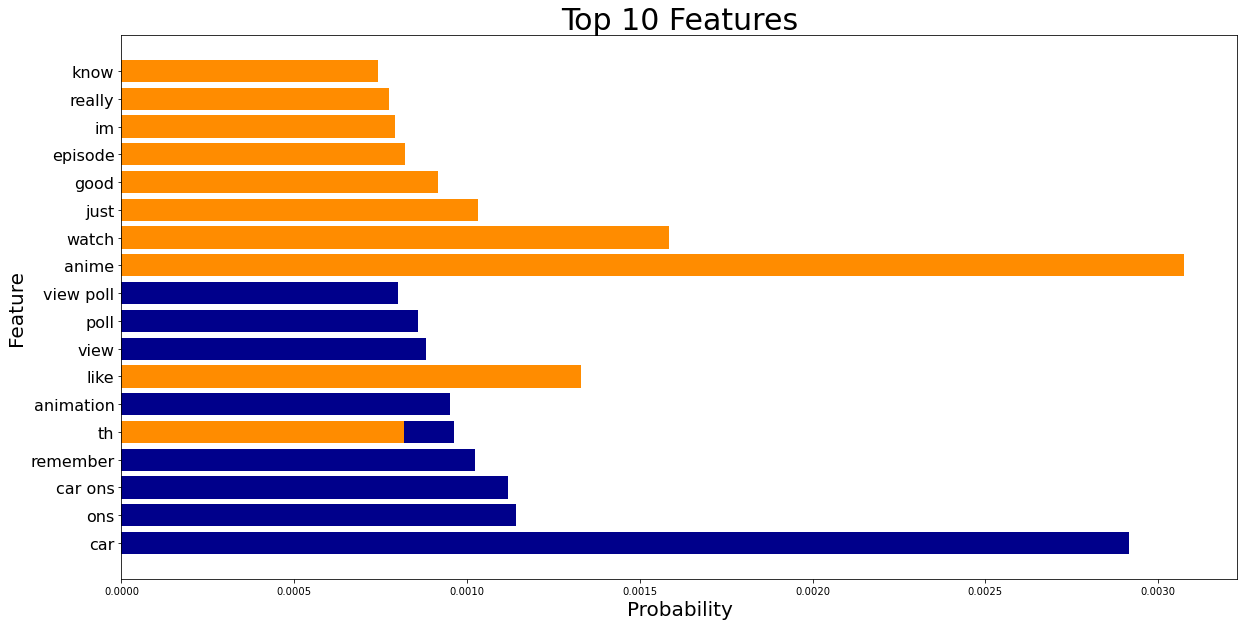

In [47]:
# plot the results from the NB dataframes
plt.figure(figsize=(20,10))
cartoon = nb_feat_importance_nfl.sort_values('probability', ascending=False).head(10)
anime = nb_feat_importance_nba.sort_values('probability', ascending=False).head(10)

plt.barh(nfl.index, nfl['probability'], color='darkblue')
plt.barh(nba.index, nba['probability'], color='darkorange')
plt.yticks(size=16)

plt.title('Top 10 Features', fontsize=30)
plt.xlabel('Probability', fontsize=20)
plt.ylabel('Feature', fontsize=20);

In [48]:
nb_counts_cartoon = pd.DataFrame(tfidf_nb.feature_count_[0], train_df.columns, columns=['weighted_count'])
nb_counts_anime = pd.DataFrame(tfidf_nb.feature_count_[1], train_df.columns, columns=['weighted_count'])

In [49]:
nb_counts_anime.sort_values(by=['weighted_count'], ascending=False).head(20)

,weighted_count
anime,38.351031
watch,19.283764
like,16.002489
just,12.185898
good,10.709928
episode,9.496086
th,9.463643
im,9.120118
really,8.902989
know,8.506339


In [50]:
nb_counts_cartoon.sort_values(by=['weighted_count'], ascending=False).head(20)


,weighted_count
car,35.265886
ons,13.202106
car ons,12.900789
remember,11.704899
th,10.951843
animation,10.821650
like,10.376962
view,9.952902
poll,9.668625
view poll,8.962838


In [51]:
# define function to create confusion matrix and classification report
def make_cm(model, X, y, names):
    
    #get predictions from the model and plot the against the actual values in a confusion matrix
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    
    # convert confusion matrix to dataframe
    cols = ['pred_' + c for c in names]
    dfcm = pd.DataFrame(cm, columns=cols, index=names)
    
    # print confusion matrix and classification report
    print(dfcm)
    print("--------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    
    # credit adi brohstein for the basis for this code


In [52]:
# run confusion matrix function
make_cm(tfidf_nb, test_raw, y_test, ['r/anime', 'r/cartoon'])

           pred_r/anime  pred_r/cartoon
r/anime             230              15
r/cartoon            29             154
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       245
           1       0.91      0.84      0.88       183

    accuracy                           0.90       428
   macro avg       0.90      0.89      0.89       428
weighted avg       0.90      0.90      0.90       428



Confusion matrix, without normalization
[[230  15]
 [ 29 154]]


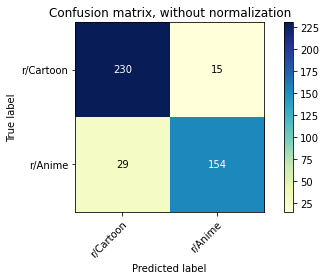

In [53]:

# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['r/Cartoon', 'r/Anime'])

# generate predictions
y_pred = tfidf_nb.predict(test_raw)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

In [54]:
# use the parameters found in the gridsearch
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000, max_df=0.60)

In [55]:
# run the Count Vectorized model with the optimal hyperparameters
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2), max_features=20000, max_df=0.60)
train_raw = cvec.fit_transform(X_train)
train_df = pd.DataFrame(train_raw.toarray(), columns=cvec.get_feature_names())

test_raw = cvec.transform(X_test)
test_df = pd.DataFrame(test_raw.toarray(), columns=cvec.get_feature_names())

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# fit the multinomail NB model
cvec_nb = MultinomialNB()
cvec_nb.fit(train_df, y_train)

MultinomialNB()

In [56]:
vec_nb = MultinomialNB()
cvec_nb.fit(train_df, y_train)

MultinomialNB()

In [57]:
# score 
cvec_nb.score(test_raw, y_test)

0.8855140186915887

In [58]:
# create dataframes for plotting NB results
# note that exponential is taken from the log probability to get the actual probability for each feature
nb_feat_importance_cartoon = pd.DataFrame(np.exp(cvec_nb.feature_log_prob_[0]), train_df.columns, columns=['probability'])
nb_feat_importance_anime = pd.DataFrame(np.exp(cvec_nb.feature_log_prob_[1]), train_df.columns, columns=['probability'])

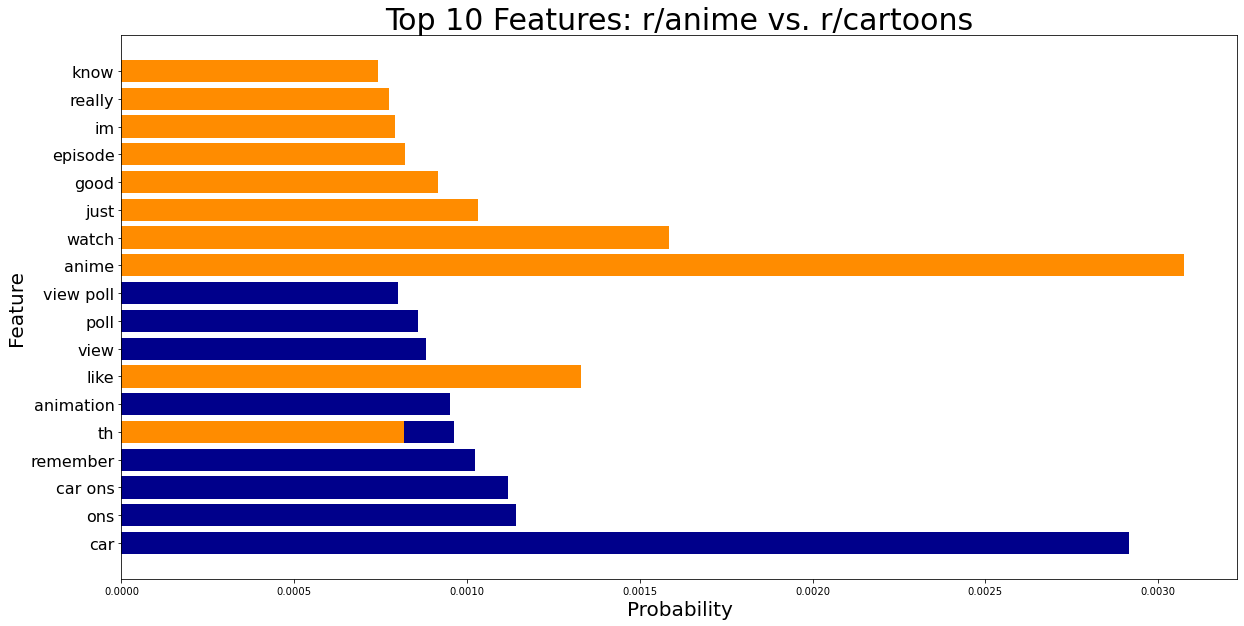

In [59]:
# plot the results from the NB dataframes
plt.figure(figsize=(20,10))
nfl = nb_feat_importance_nfl.sort_values('probability', ascending=False).head(10)
nba = nb_feat_importance_nba.sort_values('probability', ascending=False).head(10)

plt.barh(nfl.index, nfl['probability'], color='darkblue')
plt.barh(nba.index, nba['probability'], color='darkorange')
plt.yticks(size=16)

plt.title('Top 10 Features: r/anime vs. r/cartoons', fontsize=30)
plt.xlabel('Probability', fontsize=20)
plt.ylabel('Feature', fontsize=20);

In [60]:
make_cm(cvec_nb, test_raw, y_test, ['r/cartoon', 'r/anime'])

           pred_r/cartoon  pred_r/anime
r/cartoon             207            38
r/anime                11           172
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       245
           1       0.82      0.94      0.88       183

    accuracy                           0.89       428
   macro avg       0.88      0.89      0.88       428
weighted avg       0.89      0.89      0.89       428



In [61]:
nb_features(cvec, cvec_nb, class_labels=['r/cartoon', 'r/anime'])

Important words in classifying posts for r/cartoon
r/cartoon 0.009642521166509871 car
r/cartoon 0.0042594334692170974 like
r/cartoon 0.003580014633636457 remember
r/cartoon 0.003370962684227028 th
r/cartoon 0.003135779241141421 ons
r/cartoon 0.002952858785408173 car ons
r/cartoon 0.002534754886589316 watch
r/cartoon 0.00209051949409428 know
r/cartoon 0.0019075990383610312 just
r/cartoon 0.001698547088951603 help
r/cartoon 0.0016724155952754242 shows
r/cartoon 0.0016462841015992462 im
r/cartoon 0.0016462841015992462 amp
r/cartoon 0.0015678896205707103 episode
r/cartoon 0.0014894951395421755 time
r/cartoon 0.0013327061774851046 character
r/cartoon 0.0013065746838089262 characters
r/cartoon 0.0012804431901327475 new
r/cartoon 0.0012543116964565683 series
r/cartoon 0.0012281802027803899 look
 
 
Important words in classifying posts for r/anime
r/anime 0.01275177780259876 anime
r/anime 0.006143192226069473 watch
r/anime 0.00595703488588555 like
r/anime 0.004244387356193456 just
r/anime 0.00